# Email Marketing Campaigns Optimization Model with NLP

### Jupyter Notebook 3/10

In [1]:
import sys
sys.path.append('..')


import warnings
warnings.filterwarnings('ignore')

# Get files
from campaigns.getinputdata import CampaignsEDAFileGetInfo

# Feature Engineering
from campaigns.modeling.preprocessing import KPIcreator

# Texts Preprocessing
from campaigns.modeling.nlp import CampaignsCleaner, TextsCleaner

In [2]:
# Getting input

main_model = CampaignsEDAFileGetInfo(dataroot='../../../datasets/output/sample_01/', datafile='output_02.csv')

## 4. Feature Engineering

**Steps**

- 4.1. Creating new variables within the dataframe which correspond to the Email Marketing KPIs that we want to observe: `open_rate`, `ctr`, `ctor`.

- 4.2. First Model: Feature Engineering for textual variables using NLP Techniques and ML to detect Verticals.

- 4.3. Creating new variables: `open_rate_benchmark`, `ctr_benchmark`, `ctor_benchmark`, `open_rate_result`, `ctr_result`, `ctor_result`. 

- 4.4. Feature Selection with ColumnTransformer.


### 4.1. Creating new variables `open_rate`, `ctr` and `ctor`

In [3]:
# Creating an instance
# Creating new variables (KPIS)

main_model_feat = KPIcreator(main_model.campaigns_df)
main_model_feat.kpi_creator()
open_rate_table, ctr_table, ctor_table = main_model_feat.kpi_describe()

#### Observing new variables

In [4]:
open_rate_table

open_rate                                   
                 count mean  std  min  25%  50%  75%  max
customer_cat                                             
1             6,431.00 0.51 0.16 0.09 0.41 0.52 0.63 0.93
2            15,263.00 0.58 0.13 0.08 0.51 0.60 0.67 0.96
3             9,548.00 0.70 0.11 0.09 0.66 0.72 0.77 0.99
4            18,020.00 0.75 0.11 0.11 0.70 0.76 0.81 1.00
5            50,542.00 0.81 0.10 0.09 0.77 0.82 0.87 1.00

In [5]:
ctr_table

ctr                                   
                 count mean  std  min  25%  50%  75%  max
customer_cat                                             
1             6,431.00 0.21 0.17 0.00 0.00 0.22 0.35 0.78
2            15,263.00 0.26 0.17 0.00 0.12 0.28 0.40 0.93
3             9,548.00 0.36 0.18 0.00 0.25 0.39 0.48 0.94
4            18,020.00 0.37 0.21 0.00 0.22 0.40 0.53 1.00
5            50,542.00 0.44 0.23 0.00 0.29 0.48 0.61 1.00

In [6]:
ctor_table

ctor                                   
                 count mean  std  min  25%  50%  75%  max
customer_cat                                             
1             6,431.00 0.38 0.27 0.00 0.00 0.43 0.59 1.16
2            15,263.00 0.42 0.25 0.00 0.25 0.48 0.62 1.26
3             9,548.00 0.50 0.22 0.00 0.38 0.54 0.66 1.00
4            18,020.00 0.49 0.25 0.00 0.32 0.54 0.68 1.00
5            50,542.00 0.53 0.26 0.00 0.38 0.59 0.73 1.05

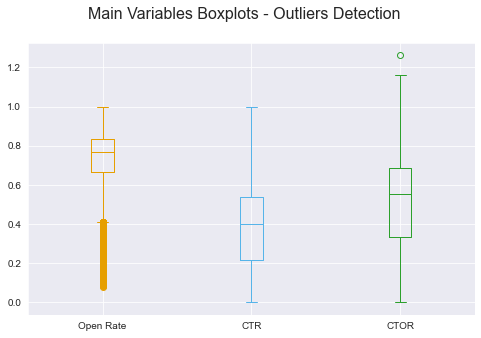

In [7]:
main_model_feat.plot_outliers()

In [8]:
open_rate_lower_bound, open_rate_upper_bound = main_model_feat.detect_outliers('open_rate')
ctr_lower_bound, ctr_upper_bound = main_model_feat.detect_outliers('ctr')
ctor_lower_bound, ctor_upper_bound = main_model_feat.detect_outliers('ctor')


Outliers:
4014

Outliers:
0

Outliers:
1


#### Handling outliers

In [9]:
main_model_feat.handle_outliers('open_rate', open_rate_lower_bound, open_rate_upper_bound)

Mean value after outliers treatment: 0.74


In [10]:
main_model_feat.handle_outliers('ctr', ctr_lower_bound, ctr_upper_bound)

Mean value after outliers treatment: 0.38


In [11]:
main_model_feat.handle_outliers('ctor', ctor_lower_bound, ctor_upper_bound)

Mean value after outliers treatment: 0.49


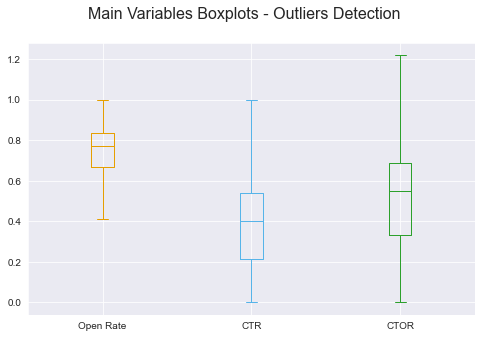

In [12]:
main_model_feat.plot_outliers()

#### Observing distribution by customer category

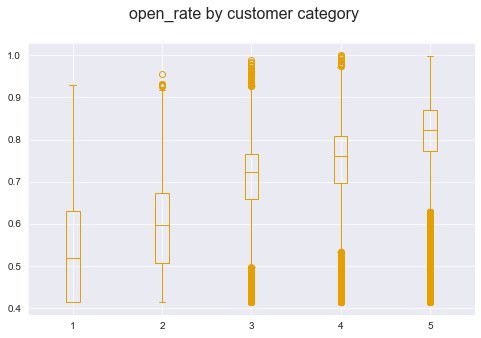

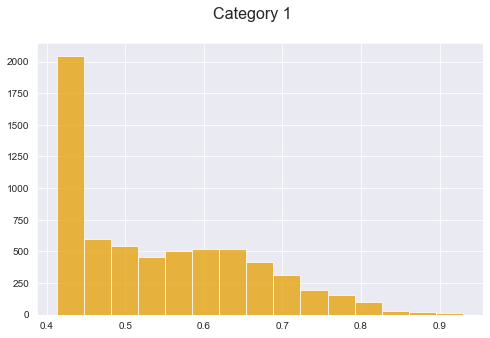

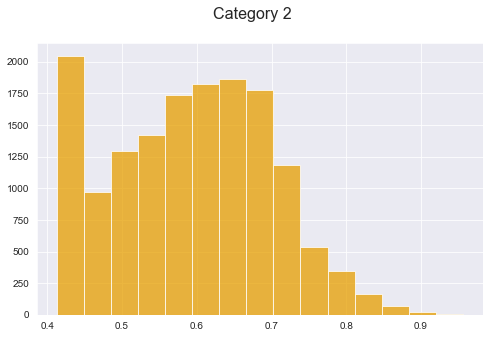

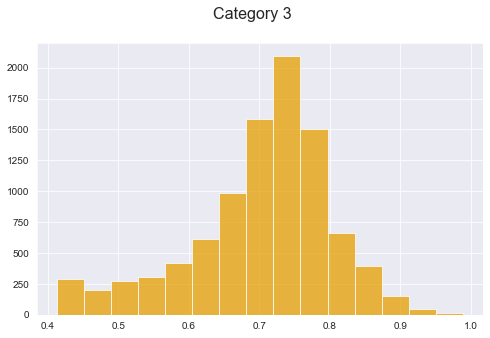

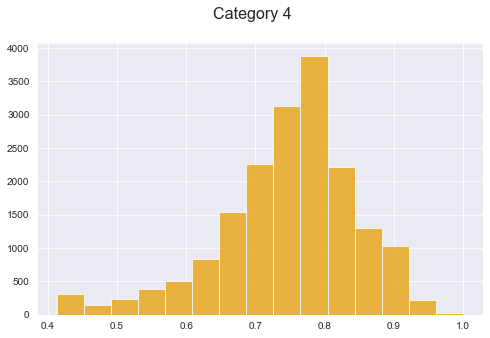

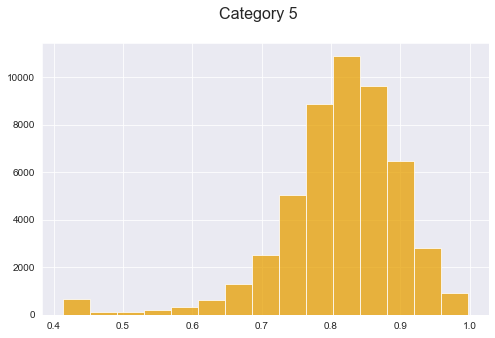

In [13]:
main_model_feat.bivariate_plotter('open_rate')

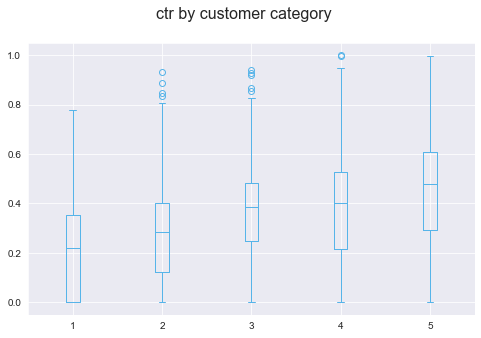

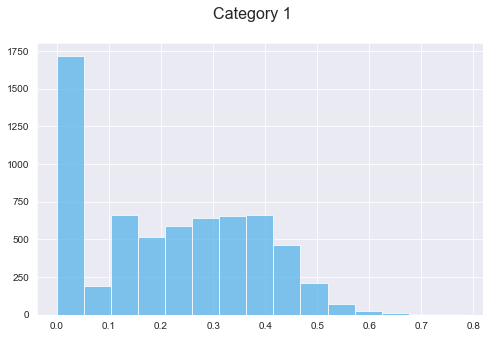

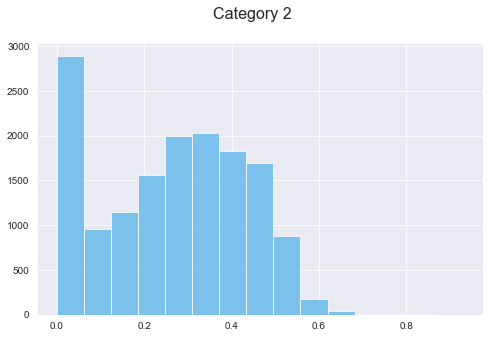

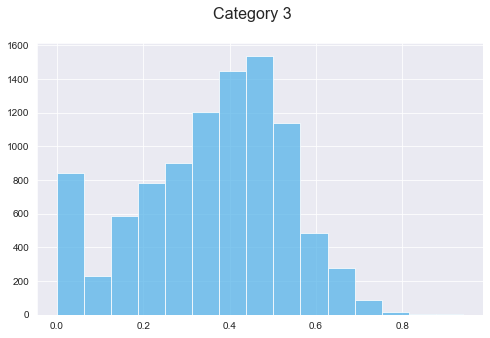

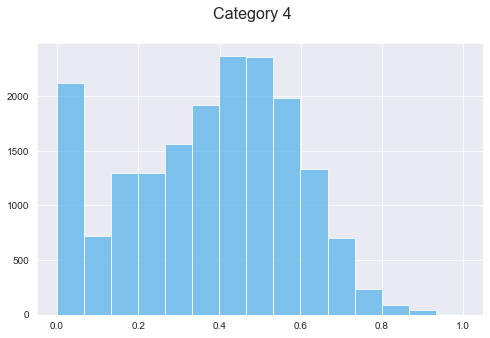

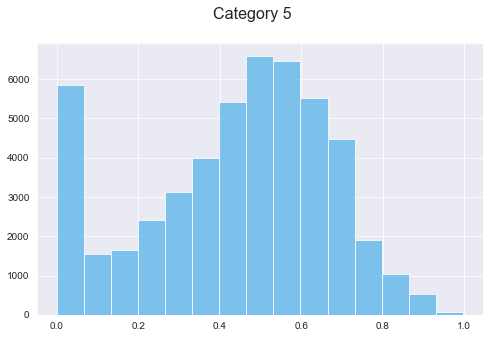

In [14]:
main_model_feat.bivariate_plotter('ctr')

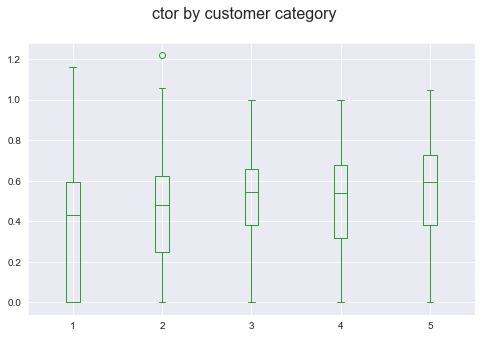

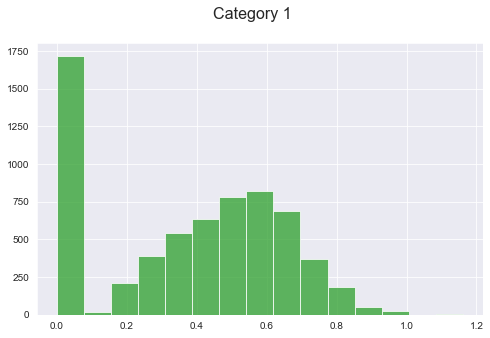

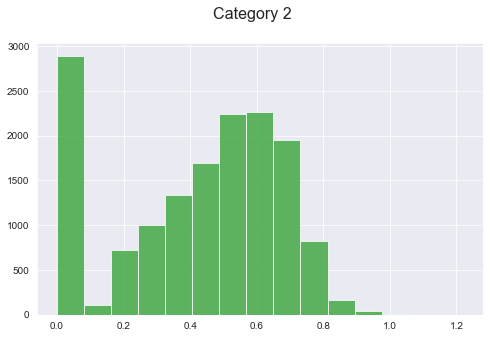

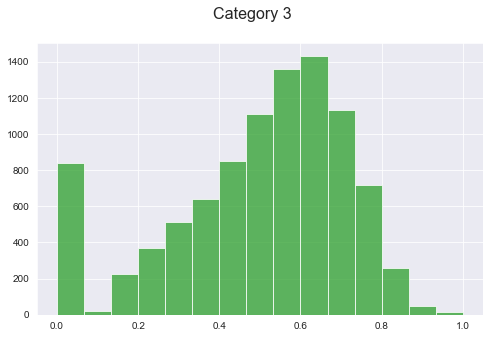

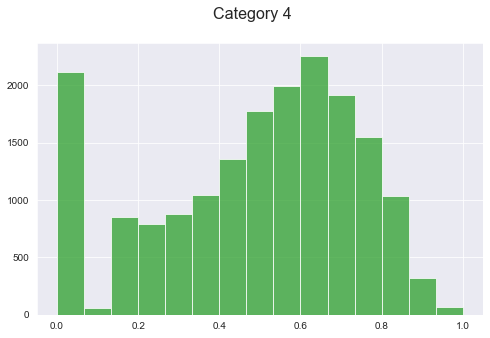

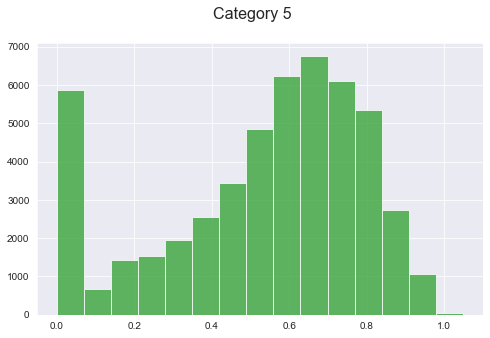

In [15]:
main_model_feat.bivariate_plotter('ctor')

In [16]:
main_model_feat.campaigns_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99804 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sender        99804 non-null  int64  
 1   subject       99804 non-null  object 
 2   date_sent     99804 non-null  object 
 3   total_sent    99804 non-null  float64
 4   customer_cat  99804 non-null  int64  
 5   opens         99804 non-null  float64
 6   clicks        99804 non-null  float64
 7   sector        12058 non-null  object 
 8   message       99796 non-null  object 
 9   campaign_id   99804 non-null  int64  
 10  open_rate     99804 non-null  float64
 11  ctr           99804 non-null  float64
 12  ctor          99804 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 10.7+ MB


### 4.2. Texts Feature Engineering

**Problem**

- Multiclass supervised text classification (machine learning approach)

**Challenge**

- Transforming the unstructured text data from the column `message` into measurable features.

**Preprocessing Steps**

- 4.2.1. Observing messages and removing duplicated users and empty messages.
- 4.2.2. Preprocessing texts: lowering, removing punctuation marks and non-words.
- 4.2.3. Removing noisy data: detecting irrelevant ngrams and removing them.
- 4.2.4. Filtering by language.
- 4.2.5. Vectorization: Baseline Model using BoW Approach.
- 4.2.6. Detecting Verticals: Machine Learning Model.
- 4.2.7. Trying to improve the model using a different vectorization approach: TF-IDF & Embeddings.

#### 4.2.1. Removing duplicated users and empty messages

In [17]:
# Creating an instance

vertical_model = CampaignsCleaner(main_model_feat.campaigns_df)

In [18]:
# Removing duplicated users

vertical_model.duplicated_users_remover()

Number of campaigns within the dataset after removing users with duplicated accounts:  98621


In [19]:
# Removing empty messages

vertical_model.empty_messages_remover()

Number of campaigns within the dataset after removing empty messages:  98613


#### 4.2.2. Preprocessing text columns: `subject` and `message`

In [20]:
# Creating an instance

vertical_model = TextsCleaner(vertical_model.campaigns_df)

In [21]:
# Checking how many elements we have in the text before removing nonwords

vertical_model.word_counter('subject', 'message')

Total number of words in subject:  829409
Total number of words in message:  31335335


In [22]:
# Removing non words and counting elements

%time vertical_model.clean_texts()

CPU times: user 16min 17s, sys: 1.27 s, total: 16min 18s
Wall time: 16min 20s


In [23]:
vertical_model.word_counter('clean_subject', 'clean_message')

Total number of words in subject:  749892
Total number of words in message:  28552463


In [24]:
vertical_model.campaigns_df.columns

Index(['sender', 'subject', 'date_sent', 'total_sent', 'customer_cat', 'opens',
       'clicks', 'sector', 'message', 'campaign_id', 'open_rate', 'ctr',
       'ctor', 'clean_subject', 'clean_message'],
      dtype='object')

In [25]:
# Saving file

vertical_model.save_final_df('../../../datasets/output/sample_01/', 'output_03.csv')